# Dangerous Heartbeat Detection: AI Cardiac Sound Analysis

### Importing Dataset related libraries and Understanding the Dataset

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import IPython.display as ipd

In [2]:
# Load the labels
labels = pd.read_csv('Dangerous-Heartbeat-Dataset-(DHD)/labels.csv')

In [3]:
# Display the first few rows of the labels
print(labels.head())

# Check the distribution of classes
print(labels['label'].value_counts())

   Unnamed: 0 set                    filename     label
0           0   A  artifact__201012172012.wav  artifact
1           1   A  artifact__201105040918.wav  artifact
2           2   A  artifact__201105041959.wav  artifact
3           3   A  artifact__201105051017.wav  artifact
4           4   A  artifact__201105060108.wav  artifact
label
normal        351
murmur        129
extrastole     46
artifact       40
extrahls       19
Name: count, dtype: int64


In [4]:
# Load an audio file
filename = 'Dangerous-Heartbeat-Dataset-(DHD)/audio/' + labels['filename'][0]
audio, sample_rate = librosa.load(filename, sr=None)

# Display the audio
ipd.Audio(audio, rate=sample_rate)

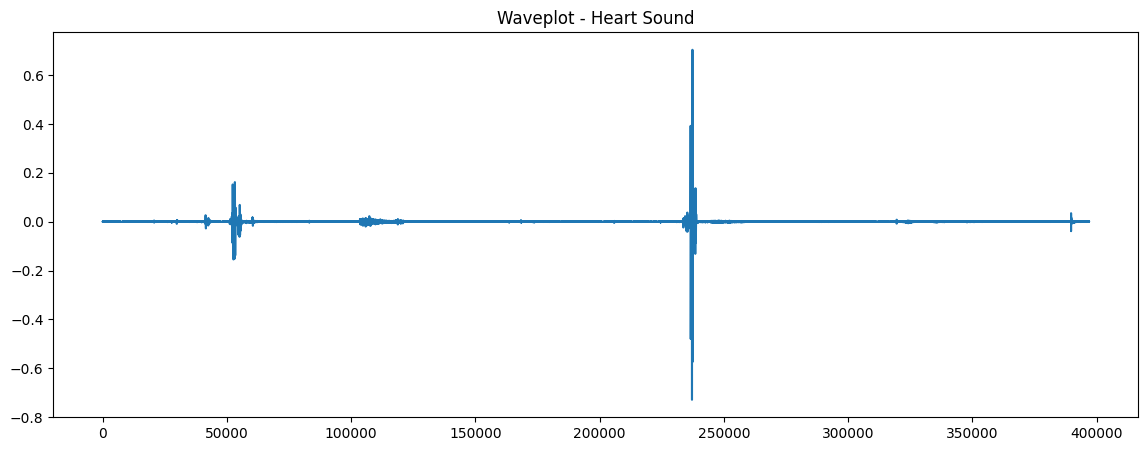

In [5]:
# Plot the audio file
plt.figure(figsize=(14, 5))
plt.plot(audio)
plt.title('Waveplot - Heart Sound')
plt.show()

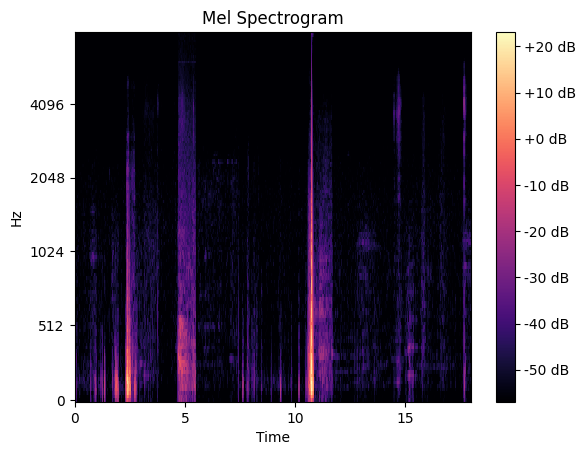

In [6]:
# Generate and display a spectrogram
spectrogram = librosa.feature.melspectrogram(y=audio, sr=sample_rate)
spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(spectrogram, y_axis='mel', fmax=8000, x_axis='time')
plt.title('Mel Spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.show()

### Data Preprocessing

In [7]:
# Initialize lists to hold spectrograms and labels
spectrograms = []
label_list = []

In [8]:
# Define a fixed length for the spectrograms
fixed_length = 1000  # We may need to adjust this value

# Iterate over each audio file
for index, row in labels.iterrows():
    # Load the audio file
    filename = 'Dangerous-Heartbeat-Dataset-(DHD)/audio/' + row['filename']
    audio, sample_rate = librosa.load(filename, sr=None)

    # Generate the spectrogram
    spectrogram = librosa.feature.melspectrogram(y=audio, sr=sample_rate)
    spectrogram = librosa.power_to_db(spectrogram)

    # Pad or truncate the spectrogram to the fixed length
    if spectrogram.shape[1] > fixed_length:
        spectrogram = spectrogram[:, :fixed_length]
    else:
        padding = fixed_length - spectrogram.shape[1]
        spectrogram = np.pad(spectrogram, ((0, 0), (0, padding)), 'constant')

    # Append the spectrogram and label to the respective lists
    spectrograms.append(spectrogram)
    label_list.append(row['label'])

In [9]:
# Convert the lists to numpy arrays
spectrograms = np.array(spectrograms)
label_list = np.array(label_list)

# Print the shapes of the arrays to check
print(spectrograms.shape)
print(label_list.shape)

(585, 128, 1000)
(585,)


### Exploratory Data Analysis(EDA)

label
normal        351
murmur        129
extrastole     46
artifact       40
extrahls       19
Name: count, dtype: int64


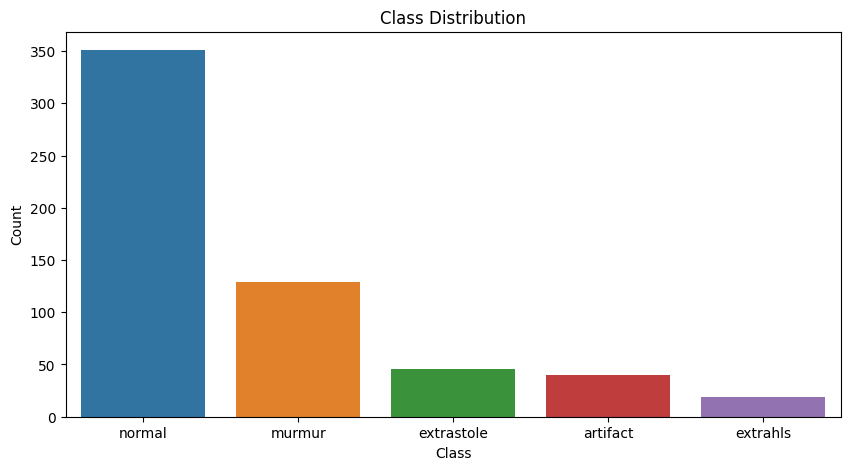

In [10]:
# Analyze the distribution of different classes
class_distribution = labels['label'].value_counts()
print(class_distribution)

# Plot the class distribution
plt.figure(figsize=(10, 5))
sns.barplot(x=class_distribution.index, y=class_distribution.values)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [11]:
# Listen to samples from each class
for label in class_distribution.index:
    sample_file = labels[labels['label'] == label]['filename'].values[0]
    print(f'Class: {label}')
    filename = 'Dangerous-Heartbeat-Dataset-(DHD)/audio/' + sample_file
    audio, sample_rate = librosa.load(filename, sr=None)
    ipd.display(ipd.Audio(audio, rate=sample_rate))

Class: normal


Class: murmur


Class: extrastole


Class: artifact


Class: extrahls


Class: normal


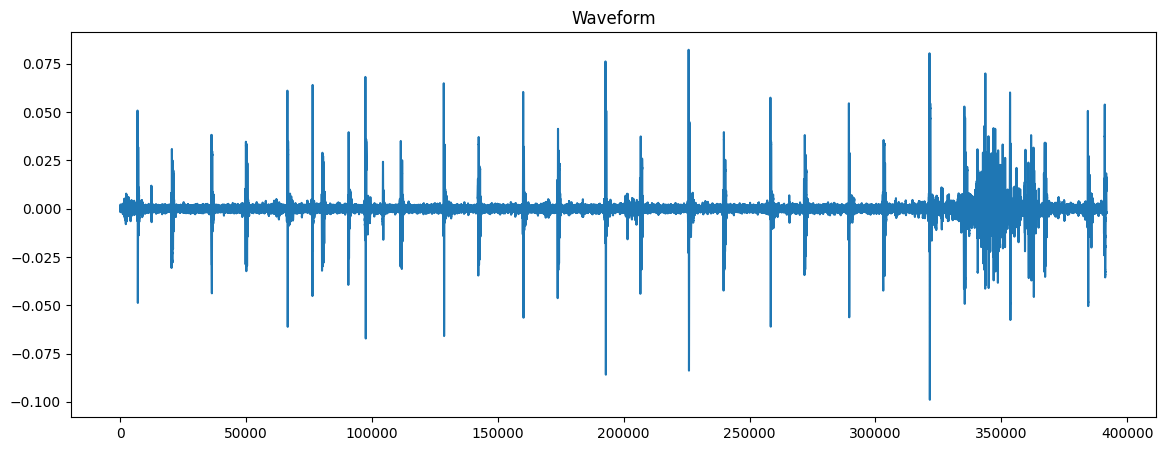

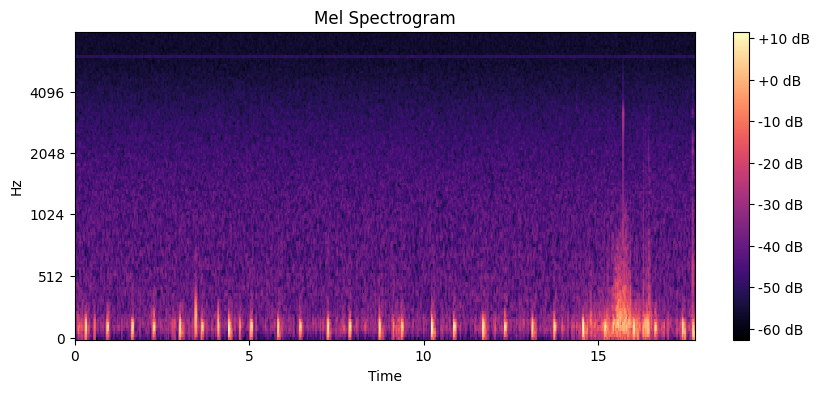

Class: murmur


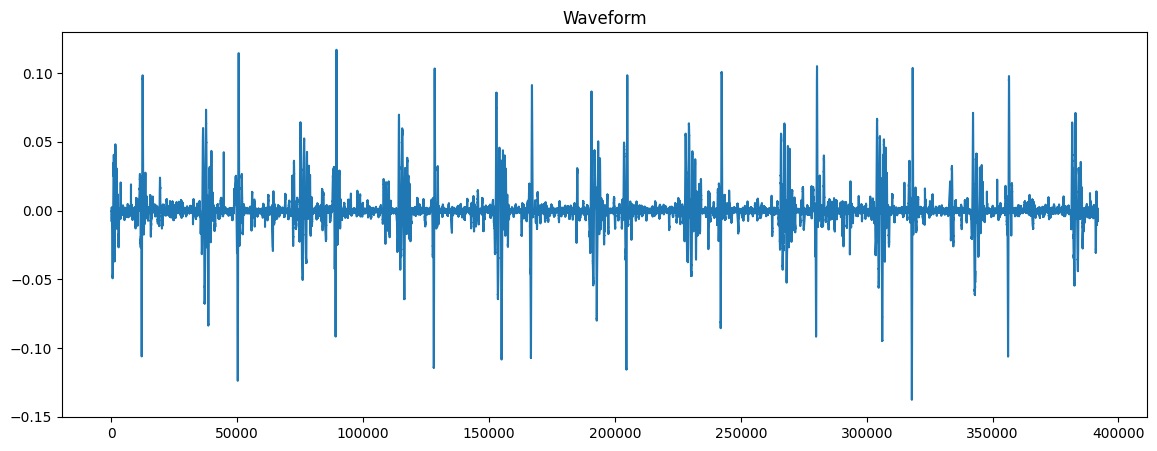

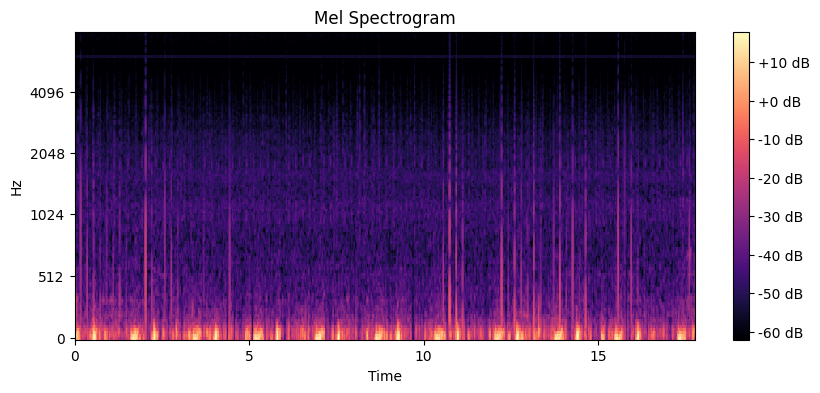

Class: extrastole


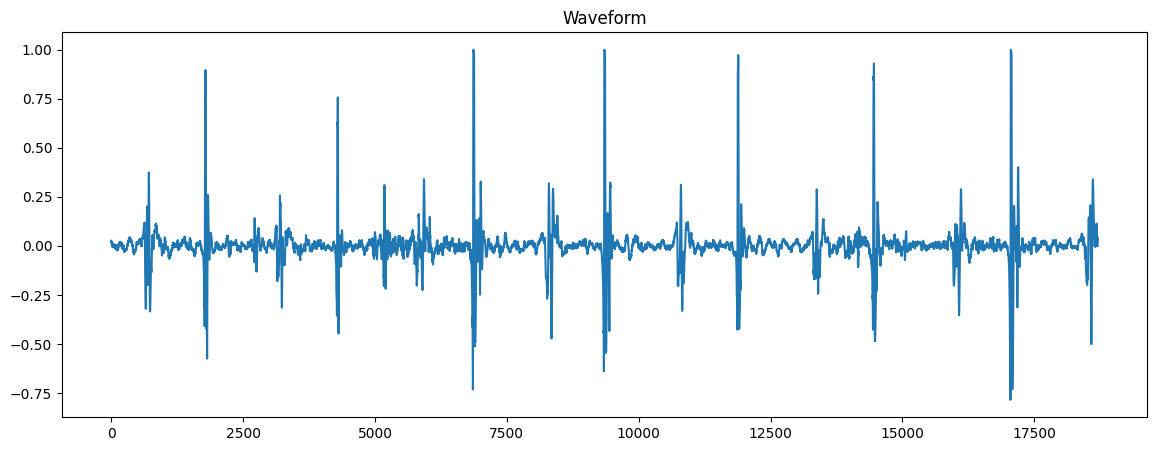

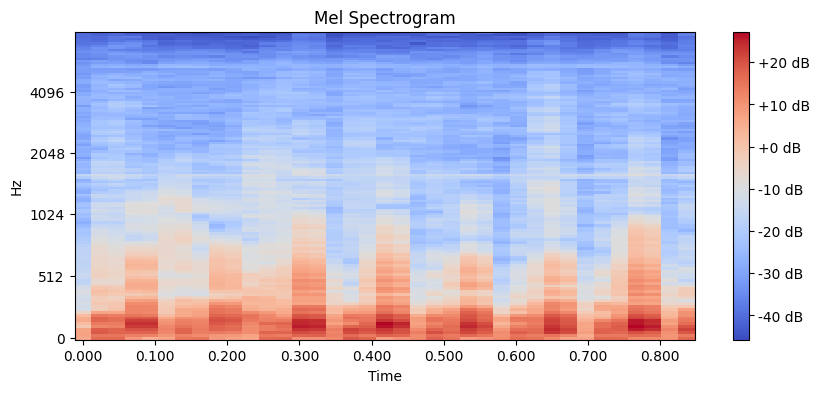

Class: artifact


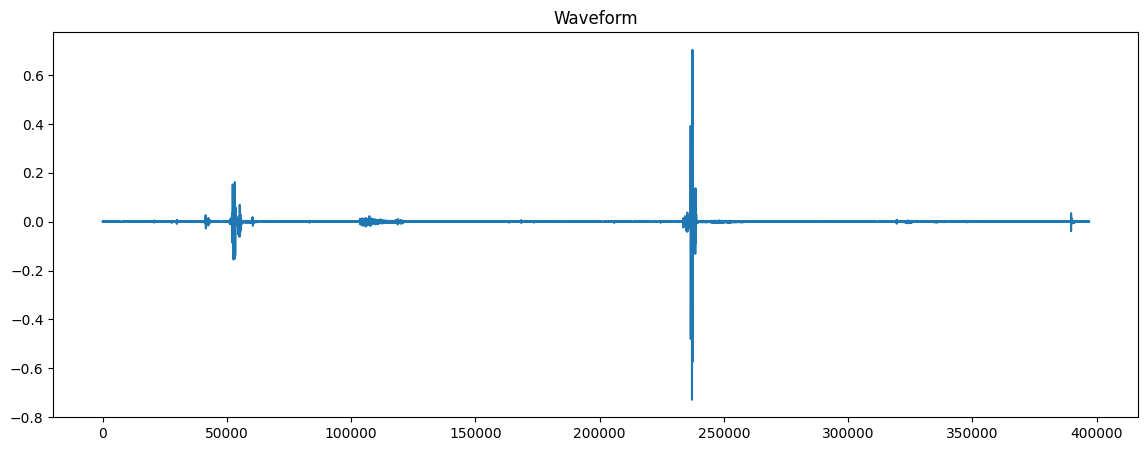

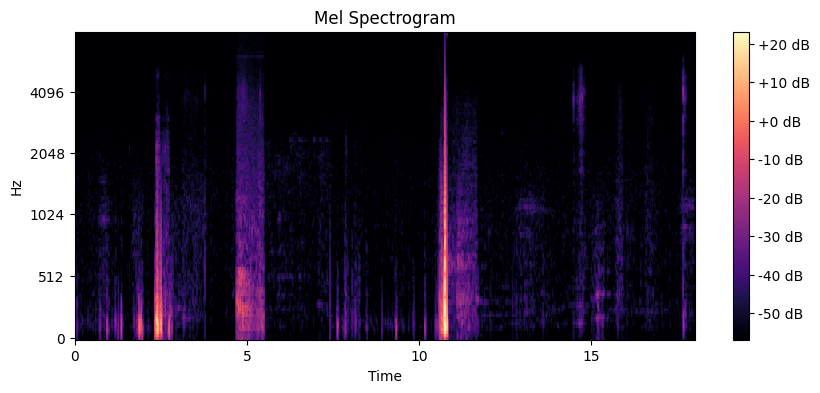

Class: extrahls


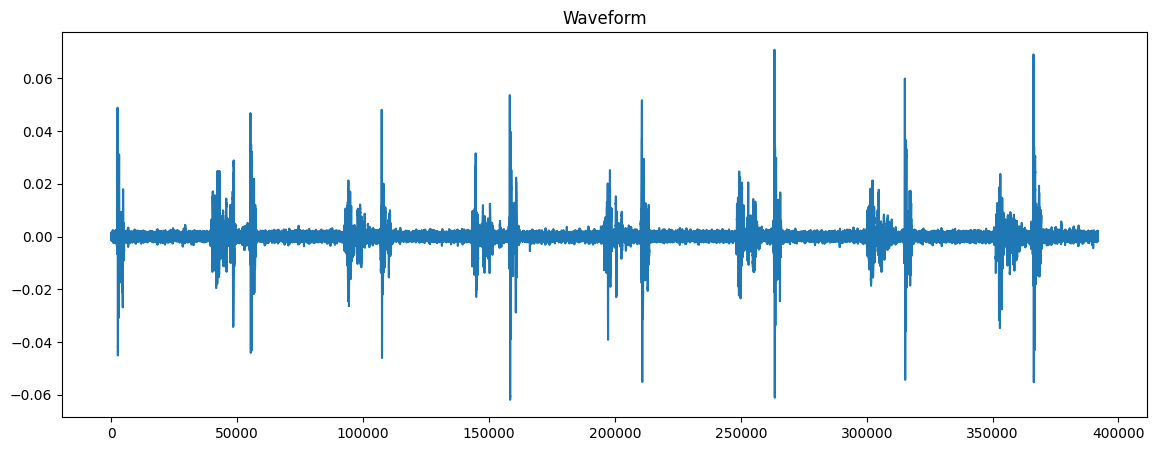

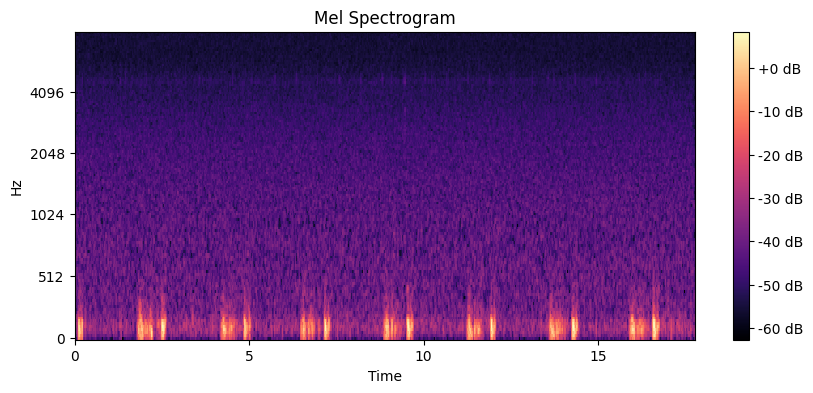

In [12]:
# Visualize the audio files
for label in class_distribution.index:
    sample_file = labels[labels['label'] == label]['filename'].values[0]
    print(f'Class: {label}')
    filename = 'Dangerous-Heartbeat-Dataset-(DHD)/audio/' + sample_file
    audio, sample_rate = librosa.load(filename, sr=None)
    
    # Plot the waveform
    plt.figure(figsize=(14, 5))
    plt.plot(audio)
    plt.title('Waveform')
    plt.show()
    
    # Generate and display a spectrogram
    spectrogram = librosa.feature.melspectrogram(y=audio, sr=sample_rate)
    spectrogram = librosa.power_to_db(spectrogram)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(spectrogram, y_axis='mel', fmax=8000, x_axis='time')
    plt.title('Mel Spectrogram')
    plt.colorbar(format='%+2.0f dB')
    plt.show()

### Spliting Test and Train Data

In [13]:
# Import necessary libraries
from sklearn.model_selection import train_test_split

In [14]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(spectrograms, label_list, test_size=0.2, stratify=label_list, random_state=42)

# Further split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

# Print the shapes of the datasets to check
print(f'Training set: {X_train.shape}, {y_train.shape}')
print(f'Validation set: {X_val.shape}, {y_val.shape}')
print(f'Test set: {X_test.shape}, {y_test.shape}')

Training set: (374, 128, 1000), (374,)
Validation set: (94, 128, 1000), (94,)
Test set: (117, 128, 1000), (117,)


### Importing ML Model Specific Libaries

In [15]:
# Import necessary libraries
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder

### Model Selection

In [16]:
# Define the model architecture
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 1000, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))  # Replace 5 with the number of classes in your dataset

# Compile the model
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 998, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 499, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 497, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 248, 64)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 246, 64)       36928     
                                                                 
 flatten (Flatten)           (None, 440832)            0

### Model Training

In [17]:
# Reshape the data to fit the model
X_train = X_train.reshape(X_train.shape[0], 128, 1000, 1)
X_val = X_val.reshape(X_val.shape[0], 128, 1000, 1)
X_test = X_test.reshape(X_test.shape[0], 128, 1000, 1)

# Initialize the encoder
encoder = LabelEncoder()

# Fit the encoder and transform the labels
y_train = encoder.fit_transform(y_train)
y_val = encoder.transform(y_val)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

Epoch 1/10
12/12 [==============================] - 85s 7s/step - loss: 27.7406 - accuracy: 0.4759 - val_loss: 1.1389 - val_accuracy: 0.5745
Epoch 2/10
12/12 [==============================] - 79s 7s/step - loss: 1.0862 - accuracy: 0.6016 - val_loss: 0.9205 - val_accuracy: 0.6809
Epoch 3/10
12/12 [==============================] - 80s 7s/step - loss: 0.9358 - accuracy: 0.6818 - val_loss: 0.8796 - val_accuracy: 0.6915
Epoch 4/10
12/12 [==============================] - 78s 7s/step - loss: 0.8868 - accuracy: 0.6791 - val_loss: 0.8997 - val_accuracy: 0.6702
Epoch 5/10
12/12 [==============================] - 79s 7s/step - loss: 0.7485 - accuracy: 0.7273 - val_loss: 0.9189 - val_accuracy: 0.7021
Epoch 6/10
12/12 [==============================] - 79s 7s/step - loss: 0.7146 - accuracy: 0.7246 - val_loss: 0.9414 - val_accuracy: 0.6383
Epoch 7/10
12/12 [==============================] - 77s 6s/step - loss: 0.7182 - accuracy: 0.7460 - val_loss: 0.9854 - val_accuracy: 0.6915
Epoch 8/10
12/12 [=

### Model Evaluation

In [18]:
# Import necessary libraries
from sklearn.metrics import classification_report, confusion_matrix

In [19]:
y_test_encoded = encoder.transform(y_test)

# Predict the classes on test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Now use y_test_encoded for the classification report and confusion matrix
print(classification_report(y_test_encoded, y_pred_classes))
print(confusion_matrix(y_test_encoded, y_pred_classes))

4/4 [==============================] - 7s 2s/step
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         8
           1       0.50      0.25      0.33         4
           2       0.00      0.00      0.00         9
           3       0.48      0.46      0.47        26
           4       0.72      0.77      0.74        70

    accuracy                           0.64       117
   macro avg       0.47      0.50      0.47       117
weighted avg       0.60      0.64      0.62       117

[[ 8  0  0  0  0]
 [ 1  1  0  0  2]
 [ 0  0  0  2  7]
 [ 0  1  1 12 12]
 [ 3  0  2 11 54]]


### Model Deployment

In [20]:
# Save the model
model.save('my_model.DHD')

INFO:tensorflow:Assets written to: my_model.DHD\assets


INFO:tensorflow:Assets written to: my_model.DHD\assets


In [21]:
# Later, load the model
from keras.models import load_model
model = load_model('my_model.DHD')

In [22]:
# Use the model to make a prediction
def predict(audio):
    # Preprocess the audio the same way you did for training
    spectrogram = librosa.feature.melspectrogram(y=audio, sr=sample_rate)
    spectrogram = librosa.power_to_db(spectrogram)

    # Pad or truncate the spectrogram to the fixed length
    if spectrogram.shape[1] > fixed_length:
        spectrogram = spectrogram[:, :fixed_length]
    else:
        padding = fixed_length - spectrogram.shape[1]
        spectrogram = np.pad(spectrogram, ((0, 0), (0, padding)), 'constant')

    # Reshape the spectrogram
    spectrogram = spectrogram.reshape(1, 128, 1000, 1)

    # Use the model to make a prediction
    prediction = model.predict(spectrogram)

    # Decode the prediction
    predicted_class = encoder.inverse_transform([np.argmax(prediction)])

    return predicted_class[0]

# Test the function
print(predict(audio))

1/1 [==============================] - 0s 257ms/step
murmur
